### 4th April 2021 - SGD and ALS implementation

In [49]:
def Preprocessing(path):
    path = 'C://Users//rac//Downloads//Software_5.json.gz'
    df = read_Dataset(path)
    df = df.drop_duplicates(['reviewerID','asin'])
    ratings_df = df.pivot(index = 'reviewerID', columns='asin', values='overall').fillna(0)
    ratings_df_numpy = ratings_df.to_numpy()
    
return ratings_df, ratings_df_numpy

def traintestsplit(ratings_df_numpy):
    return train_test_split(ratings_df_numpy)
# train, test, test_indexes



SyntaxError: 'return' outside function (<ipython-input-49-2296e1ecfa3e>, line 8)

Reading Dataset

In [13]:
# !pip install ipython-autotime


import pandas as pd
import gzip
import json
import numpy as np
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')
def read_Dataset(path):
  return getDF(path)

In [14]:
path = 'C://Users//rac//Downloads//All_Beauty_5.json.gz'
df = read_Dataset(path)

In [ ]:
df.head()

In [ ]:
df.overall.value_counts()

In [ ]:
df.reviewerID.value_counts()

In [ ]:
len(df.reviewerID.unique())

In [ ]:
len(df)

In [ ]:
df[df.reviewerID=='A1UQBFCERIP7VJ']

In [15]:
df = df.drop_duplicates(['reviewerID','asin'])

In [16]:
len(df)

4092

In [17]:
ratings_df = df.pivot(index = 'reviewerID', columns='asin', values='overall').fillna(0)

In [18]:
ratings_df_numpy = ratings_df.to_numpy()

In [19]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    test_indexes = []
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=1, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        test_indexes.append((user, test_ratings, ratings[user, test_ratings] ))
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test, test_indexes

train, test, test_indexes = train_test_split(ratings_df_numpy)

In [ ]:
train.shape

In [ ]:
test.shape

In [27]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [20]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [ ]:
MF_ALS = ExplicitMF(train, n_factors=2, \
                    user_reg=3.0, item_reg=3.0)
iter_array = [1, 2, 5, 10, 25, 50, 100, 500]
MF_ALS.calculate_learning_curve(iter_array, test)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

In [ ]:
plot_learning_curve(iter_array, MF_ALS)


In [ ]:
latent_factors = [1, 2, 3, 4, 5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact, \
                            user_reg=reg, item_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

In [ ]:
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

## SGD

In [25]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [ ]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

In [ ]:
plot_learning_curve(iter_array, MF_SGD)

In [ ]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

In [ ]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print(pd.Series(best_params))

In [ ]:
plot_learning_curve(iter_array, best_params['model'])

In [ ]:
print('Best regularization: {}'.format(best_params['reg']))
print('Best latent factors: {}'.format(best_params['n_factors']))
print('Best iterations: {}'.format(best_params['n_iter']))

Running above code on different databases

Dataset 1

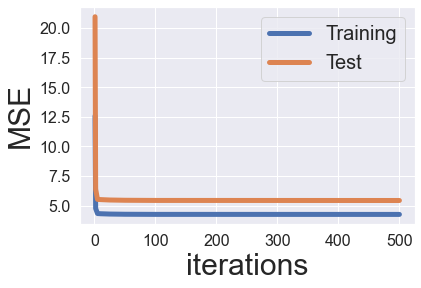

In [32]:
path = 'C://Users//rac//Downloads//All_Beauty_5.json.gz'
df = read_Dataset(path)
df = df.drop_duplicates(['reviewerID','asin'])
ratings_df = df.pivot(index = 'reviewerID', columns='asin', values='overall').fillna(0)
ratings_df_numpy = ratings_df.to_numpy()
train, test, test_indexes = train_test_split(ratings_df_numpy)

# ALS Training
MF_ALS = ExplicitMF(train, n_factors=2, learning = 'als', \
                    user_fact_reg=1.0, item_fact_reg=1.0)
iter_array = [1, 2, 5, 10, 25, 50, 100, 500]
MF_ALS.calculate_learning_curve(iter_array, test)

# ALS training plot
plot_learning_curve(iter_array, MF_ALS)



Factors: 1
Regularization: 0.01
New optimal hyperparameters
n_factors                                                    1
reg                                                       0.01
n_iter                                                     100
train_mse                                              7.97996
test_mse                                               7.86641
model        <__main__.ExplicitMF object at 0x00000248B27B8...
dtype: object
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 2
Regularization: 0.01
New optimal hyperparameters
n_factors                                                    2
reg                                                       0.01
n_iter                                                       5
train_mse                                              4.22073
test_mse                                               5.38111
model        <__main__.ExplicitMF object at 0x00000248B27B8...
dtype: object
Regularizatio

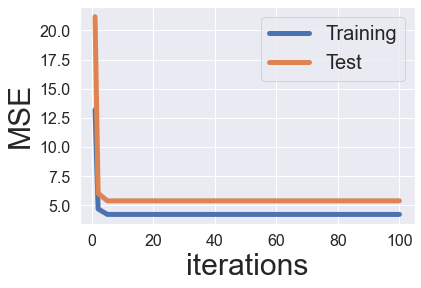

In [33]:
# ALS regularization
latent_factors = [1, 2, 3, 4, 5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact,learning='als', \
                            user_fact_reg=reg, item_fact_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
            
# plotting best ALS model
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)



Matrix Factorization with SGD
Iteration: 1
Train mse: 0.5493367896686854
Test mse: 0.5503669594984273
Iteration: 2
Train mse: 0.5431056057183038
Test mse: 0.5446865283191074
Iteration: 5
Train mse: 0.5285046935833008
Test mse: 0.5317869838997626
Iteration: 10
Train mse: 0.5081942858013623
Test mse: 0.5137327942630466
Iteration: 25
	current iteration: 10
Train mse: 0.4568650717859417
Test mse: 0.46792988845859657
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.3886165615475799
Test mse: 0.40709629440721007
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.2789219972478395
Test mse: 0.31010875672849764
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.081912641538112

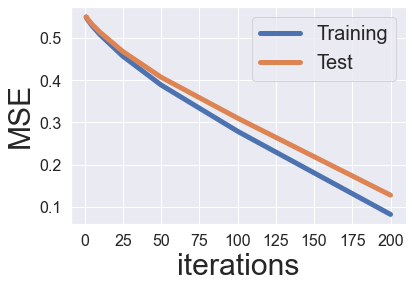

In [34]:
print('Matrix Factorization with SGD')
# SGD
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
plot_learning_curve(iter_array, MF_SGD)



Rate: 1e-05
New optimal hyperparameters
learning_rate                                                1e-05
n_iter                                                         200
train_mse                                                 0.542991
test_mse                                                  0.544547
model            <__main__.ExplicitMF object at 0x00000248B2FD8...
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                               0.0001
n_iter                                                         200
train_mse                                                 0.472694
test_mse                                                  0.482338
model            <__main__.ExplicitMF object at 0x00000248AD464...
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                                0.001
n_iter                                                         200
train_mse                                      

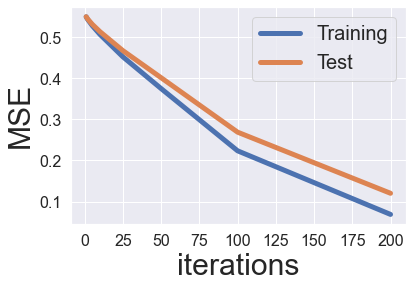

In [35]:
# finding the best parameters
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

# best parameters with regularization
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
plot_learning_curve(iter_array, best_params['model'])



In [36]:
print('Best regularization: {}'.format(best_params['reg']))
print('Best latent factors: {}'.format(best_params['n_factors']))
print('Best iterations: {}'.format(best_params['n_iter']))


Best regularization: 0.001
Best latent factors: 10
Best iterations: 200


Dataset 2

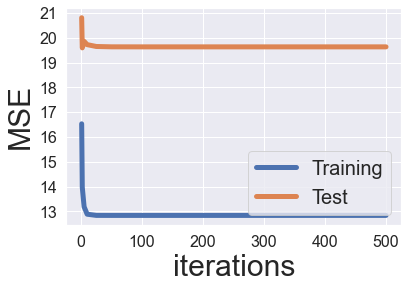

In [37]:
path = 'C://Users//rac//Downloads//Appliances_5.json.gz'
df = read_Dataset(path)
df = df.drop_duplicates(['reviewerID','asin'])
ratings_df = df.pivot(index = 'reviewerID', columns='asin', values='overall').fillna(0)
ratings_df_numpy = ratings_df.to_numpy()
train, test, test_indexes = train_test_split(ratings_df_numpy)

# ALS Training
MF_ALS = ExplicitMF(train, n_factors=2, learning = 'als', \
                    user_fact_reg=1.0, item_fact_reg=1.0)
iter_array = [1, 2, 5, 10, 25, 50, 100, 500]
MF_ALS.calculate_learning_curve(iter_array, test)

# ALS training plot
plot_learning_curve(iter_array, MF_ALS)

Factors: 1
Regularization: 0.01
New optimal hyperparameters
n_factors                                                    1
reg                                                       0.01
n_iter                                                       5
train_mse                                              14.7829
test_mse                                                18.586
model        <__main__.ExplicitMF object at 0x00000248B2747...
dtype: object
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 2
Regularization: 0.01
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 3
Regularization: 0.01
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 4
Regularization: 0.01
Regularization: 0.1
New optimal hyperparameters
n_factors                                                    4
reg                                                        0.1
n_iter                       

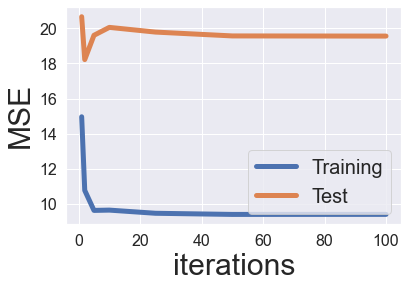

In [38]:
# ALS regularization
latent_factors = [1, 2, 3, 4, 5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact,learning='als', \
                            user_fact_reg=reg, item_fact_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
            
# plotting best ALS model
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)


Matrix Factorization with SGD
Iteration: 1
Train mse: 0.9099204452931192
Test mse: 0.9706118719242877
Iteration: 2
Train mse: 0.9032564313089795
Test mse: 0.967344761978794
Iteration: 5
Train mse: 0.8836940934039484
Test mse: 0.9577133894934187
Iteration: 10
Train mse: 0.8524493709793554
Test mse: 0.9422146709754657
Iteration: 25
	current iteration: 10
Train mse: 0.7679877734227446
Test mse: 0.8995178930627722
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.6528337106235651
Test mse: 0.8391599422305326
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.4902046180169684
Test mse: 0.7485299044506416
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.31289976725660973
T

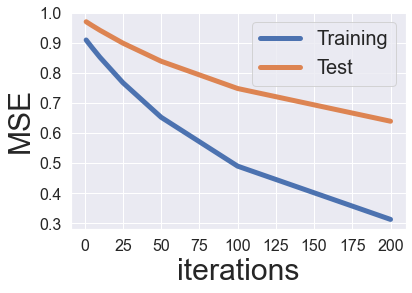

In [39]:
print('Matrix Factorization with SGD')
# SGD
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
plot_learning_curve(iter_array, MF_SGD)


Rate: 1e-05
New optimal hyperparameters
learning_rate                                                1e-05
n_iter                                                         200
train_mse                                                 0.904393
test_mse                                                  0.965889
model            <__main__.ExplicitMF object at 0x00000248B2740...
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                               0.0001
n_iter                                                         200
train_mse                                                 0.795891
test_mse                                                  0.911323
model            <__main__.ExplicitMF object at 0x00000248B2740...
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                                0.001
n_iter                                                         200
train_mse                                      

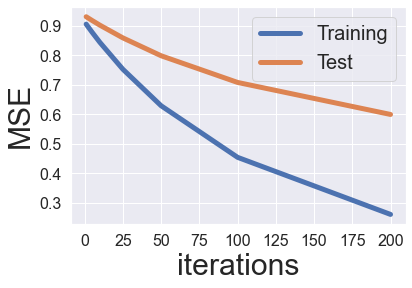

In [40]:
# finding the best parameters
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

# best parameters with regularization
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
plot_learning_curve(iter_array, best_params['model'])


In [41]:
print('Best regularization: {}'.format(best_params['reg']))
print('Best latent factors: {}'.format(best_params['n_factors']))
print('Best iterations: {}'.format(best_params['n_iter']))


Best regularization: 0.001
Best latent factors: 5
Best iterations: 200


Dataset 3

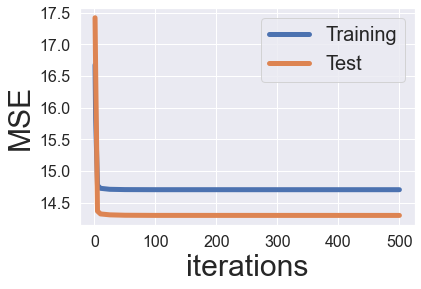

In [44]:
path = 'C://Users//rac//Downloads//Software_5.json.gz'
df = read_Dataset(path)
df = df.drop_duplicates(['reviewerID','asin'])
ratings_df = df.pivot(index = 'reviewerID', columns='asin', values='overall').fillna(0)
ratings_df_numpy = ratings_df.to_numpy()
train, test, test_indexes = train_test_split(ratings_df_numpy)

# ALS Training
MF_ALS = ExplicitMF(train, n_factors=2, learning = 'als', \
                    user_fact_reg=1.0, item_fact_reg=1.0)
iter_array = [1, 2, 5, 10, 25, 50, 100, 500]
MF_ALS.calculate_learning_curve(iter_array, test)

# ALS training plot
plot_learning_curve(iter_array, MF_ALS)

Factors: 1
Regularization: 0.01
New optimal hyperparameters
n_factors                                                    1
reg                                                       0.01
n_iter                                                     100
train_mse                                              15.2246
test_mse                                                14.631
model        <__main__.ExplicitMF object at 0x00000248AFEF9...
dtype: object
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 2
Regularization: 0.01
New optimal hyperparameters
n_factors                                                    2
reg                                                       0.01
n_iter                                                     100
train_mse                                              14.6904
test_mse                                               14.2827
model        <__main__.ExplicitMF object at 0x00000248B4178...
dtype: object
Regularizatio

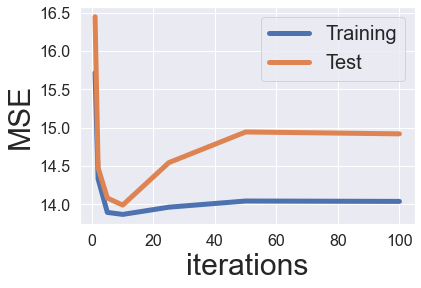

In [45]:
# ALS regularization
latent_factors = [1, 2, 3, 4, 5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact,learning='als', \
                            user_fact_reg=reg, item_fact_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
            
# plotting best ALS model
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)


Matrix Factorization with SGD
Iteration: 1
Train mse: 1.7877611987237993
Test mse: 1.8344737019842898
Iteration: 2
Train mse: 1.7505144541798627
Test mse: 1.7926717788797588
Iteration: 5
Train mse: 1.6666142228996472
Test mse: 1.7107548224169153
Iteration: 10
Train mse: 1.5701376139577345
Test mse: 1.6363658880439216
Iteration: 25
	current iteration: 10
Train mse: 1.3775992957125636
Test mse: 1.512699591950773
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 1.1791530497278537
Test mse: 1.3906573607851271
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.9668226917738562
Test mse: 1.265544963835136
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.7735935641610343
Tes

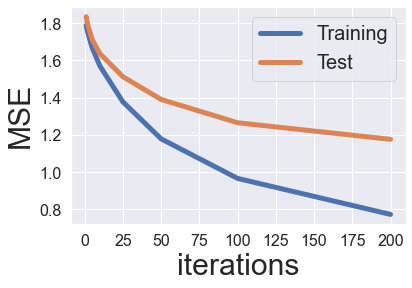

In [46]:
print('Matrix Factorization with SGD')
# SGD
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
plot_learning_curve(iter_array, MF_SGD)

Rate: 1e-05
New optimal hyperparameters
learning_rate                                                1e-05
n_iter                                                         200
train_mse                                                  1.75064
test_mse                                                   1.79224
model            <__main__.ExplicitMF object at 0x00000248B02E4...
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                               0.0001
n_iter                                                         200
train_mse                                                  1.43289
test_mse                                                   1.54698
model            <__main__.ExplicitMF object at 0x00000248B02E4...
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                                0.001
n_iter                                                         200
train_mse                                      

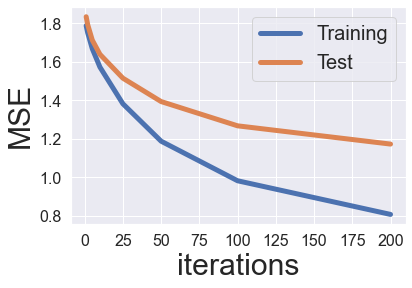

In [47]:
# finding the best parameters
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

# best parameters with regularization
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
plot_learning_curve(iter_array, best_params['model'])

In [48]:
print('Best regularization: {}'.format(best_params['reg']))
print('Best latent factors: {}'.format(best_params['n_factors']))
print('Best iterations: {}'.format(best_params['n_iter']))

Best regularization: 0.1
Best latent factors: 40
Best iterations: 200


Dataset 4

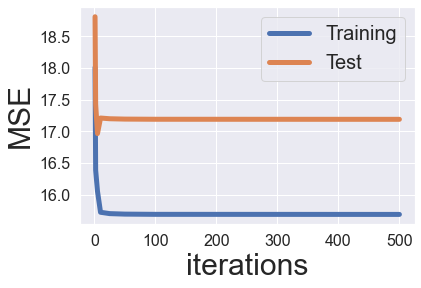

In [50]:
path = 'C://Users//rac//Downloads//Luxury_Beauty_5.json.gz'
df = read_Dataset(path)
df = df.drop_duplicates(['reviewerID','asin'])
ratings_df = df.pivot(index = 'reviewerID', columns='asin', values='overall').fillna(0)
ratings_df_numpy = ratings_df.to_numpy()
train, test, test_indexes = train_test_split(ratings_df_numpy)

# ALS Training
MF_ALS = ExplicitMF(train, n_factors=2, learning = 'als', \
                    user_fact_reg=1.0, item_fact_reg=1.0)
iter_array = [1, 2, 5, 10, 25, 50, 100, 500]
MF_ALS.calculate_learning_curve(iter_array, test)

# ALS training plot
plot_learning_curve(iter_array, MF_ALS)

Factors: 1
Regularization: 0.01
New optimal hyperparameters
n_factors                                                    1
reg                                                       0.01
n_iter                                                     100
train_mse                                              16.5577
test_mse                                               17.4853
model        <__main__.ExplicitMF object at 0x00000248ECF6A...
dtype: object
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 2
Regularization: 0.01
New optimal hyperparameters
n_factors                                                    2
reg                                                       0.01
n_iter                                                       2
train_mse                                              15.7685
test_mse                                               17.1028
model        <__main__.ExplicitMF object at 0x00000248ECF6A...
dtype: object
Regularizatio

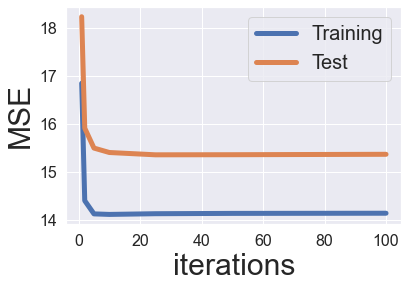

In [51]:
# ALS regularization
latent_factors = [1, 2, 3, 4, 5, 10, 20, 40, 80]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact,learning='als', \
                            user_fact_reg=reg, item_fact_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
            
# plotting best ALS model
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

Matrix Factorization with SGD
Iteration: 1
Train mse: 1.0886335855274747
Test mse: 1.1366050075962684
Iteration: 2
Train mse: 1.0764057557457372
Test mse: 1.1281300033923365
Iteration: 5
Train mse: 1.0432544964317116
Test mse: 1.1059663140013756
Iteration: 10
Train mse: 0.9959190451320994
Test mse: 1.0751334522189846
Iteration: 25
	current iteration: 10
Train mse: 0.8884459326500691
Test mse: 1.0041915092202442
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.7671488648827551
Test mse: 0.9207601725514524
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.6041923413474606
Test mse: 0.8026474300994406
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.5108639428486013
T

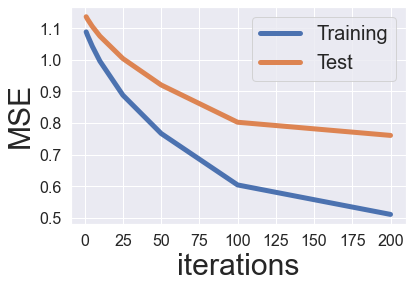

In [52]:
print('Matrix Factorization with SGD')
# SGD
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
plot_learning_curve(iter_array, MF_SGD)

In [ ]:
# finding the best parameters
iter_array = [1, 2, 5, 10]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

# best parameters with regularization
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
plot_learning_curve(iter_array, best_params['model'])

Rate: 1e-05
New optimal hyperparameters
learning_rate                                                1e-05
n_iter                                                          10
train_mse                                                  1.10035
test_mse                                                   1.14499
model            <__main__.ExplicitMF object at 0x00000248EE753...
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                               0.0001
n_iter                                                          10
train_mse                                                  1.08853
test_mse                                                   1.13662
model            <__main__.ExplicitMF object at 0x00000248EE753...
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                                0.001
n_iter                                                          10
train_mse                                      

Dataset 5

In [ ]:
path = 'C://Users//rac//Downloads//Industrial_and_Scientific_5.json.gz'
df = read_Dataset(path)
df = df.drop_duplicates(['reviewerID','asin'])
ratings_df = df.pivot(index = 'reviewerID', columns='asin', values='overall').fillna(0)
ratings_df_numpy = ratings_df.to_numpy()
train, test, test_indexes = train_test_split(ratings_df_numpy)

# ALS Training
MF_ALS = ExplicitMF(train, n_factors=2, learning = 'als', \
                    user_fact_reg=1.0, item_fact_reg=1.0)
iter_array = [1, 2, 5, 10, 25, 50, 100, 500]
MF_ALS.calculate_learning_curve(iter_array, test)

# ALS training plot
plot_learning_curve(iter_array, MF_ALS)

In [ ]:
# ALS regularization
latent_factors = [1, 2, 3, 4, 5, 10, 20]
regularizations = [0.01, 0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 2, 5, 10, 25, 50, 100]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_ALS = ExplicitMF(train, n_factors=fact,learning='als', \
                            user_fact_reg=reg, item_fact_reg=reg)
        MF_ALS.calculate_learning_curve(iter_array, test)
        min_idx = np.argmin(MF_ALS.test_mse)
        if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_ALS.train_mse[min_idx]
            best_params['test_mse'] = MF_ALS.test_mse[min_idx]
            best_params['model'] = MF_ALS
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
            
# plotting best ALS model
best_als_model = best_params['model']
plot_learning_curve(iter_array, best_als_model)

In [ ]:
print('Matrix Factorization with SGD')
# SGD
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
plot_learning_curve(iter_array, MF_SGD)

In [ ]:
# finding the best parameters
iter_array = [1, 2, 5, 10, 25]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print('New optimal hyperparameters')
        print(pd.Series(best_params))

# best parameters with regularization
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print('Factors: {}'.format(fact))
    for reg in regularizations:
        print('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print('New optimal hyperparameters')
            print(pd.Series(best_params))
plot_learning_curve(iter_array, best_params['model'])